In [47]:
import os
import torch
from trainers.torch.networks import SplitValueSharedActorCritic
from mlagents_envs.base_env import ObservationSpec, DimensionProperty, ObservationType
from mlagents.trainers.settings import NetworkSettings, TrainerSettings
from mlagents_envs.base_env import ActionSpec
from trainers.policy.torch_policy import TorchPolicy
from mlagents_envs.base_env import BehaviorSpec

In [48]:
run_name="big-map-ppo-2"
load_path = f"/home/rmarr/Projects/visibility-game-env/results/{run_name}/Seeker/checkpoint.pt"
saved_state_dict = torch.load(load_path)

In [49]:
seed = 5404
observation_specs = [ObservationSpec(
            name="position_observation",
            shape=(12,),  # 3D vector
            dimension_property=(DimensionProperty.NONE,),  # Must be a tuple
            observation_type=ObservationType.DEFAULT
        )]
action_spec = ActionSpec(
    continuous_size=0,
    discrete_branches=(5,)
)
behavior_spec = BehaviorSpec(
    observation_specs=observation_specs,
    action_spec=action_spec
)
trainer_settings = TrainerSettings(
    dual_critic=True
)
network_settings = NetworkSettings(
    deterministic=False,
    memory=None,
    hidden_units=128,
    num_layers=2,
)

stream_names = ["default"]
conditional_sigma = False
tanh_squash = False
load_critic_only = "position_only"

In [50]:
policy = TorchPolicy(
    seed=seed,
    behavior_spec=behavior_spec,
    trainer_settings=trainer_settings,
    tanh_squash=False,
    separate_critic=False,
    condition_sigma_on_obs=False,
    load_critic_only=load_critic_only
)

In [51]:
modules = policy.get_modules()

In [52]:
saved_state_dict['Policy'].keys()

odict_keys(['version_number', 'is_continuous_int_deprecated', 'continuous_act_size_vector', 'discrete_act_size_vector', 'act_size_vector_deprecated', 'memory_size_vector', 'network_body._body_endoder.seq_layers.0.weight', 'network_body._body_endoder.seq_layers.0.bias', 'network_body._body_endoder.seq_layers.2.weight', 'network_body._body_endoder.seq_layers.2.bias', 'action_model._discrete_distribution.branches.0.weight', 'action_model._discrete_distribution.branches.0.bias', 'value_heads.value_heads.extrinsic.weight', 'value_heads.value_heads.extrinsic.bias', 'position_network._body_endoder.seq_layers.0.weight', 'position_network._body_endoder.seq_layers.0.bias', 'position_network._body_endoder.seq_layers.2.weight', 'position_network._body_endoder.seq_layers.2.bias', 'crumbs_network._body_endoder.seq_layers.0.weight', 'crumbs_network._body_endoder.seq_layers.0.bias', 'crumbs_network._body_endoder.seq_layers.2.weight', 'crumbs_network._body_endoder.seq_layers.2.bias', 'importance_networ

In [53]:
position_state_dict = {k: v for k, v in saved_state_dict['Policy'].items() if 'position_network' in k or 'cr'}
importance_network_path = "/home/rmarr/Projects/visibility-game-env/informed_init/bias_importance.pt"
importance_state_dict = torch.load(importance_network_path)

In [54]:
#print(saved_state_dict['Policy'])

In [55]:
modules['Policy'].load_state_dict(position_state_dict, strict=False)
modules['Policy'].load_state_dict(importance_state_dict, strict=False)

_IncompatibleKeys(missing_keys=['version_number', 'is_continuous_int_deprecated', 'continuous_act_size_vector', 'discrete_act_size_vector', 'act_size_vector_deprecated', 'memory_size_vector', 'network_body._body_endoder.seq_layers.0.weight', 'network_body._body_endoder.seq_layers.0.bias', 'network_body._body_endoder.seq_layers.2.weight', 'network_body._body_endoder.seq_layers.2.bias', 'action_model._discrete_distribution.branches.0.weight', 'action_model._discrete_distribution.branches.0.bias', 'value_heads.value_heads.extrinsic.weight', 'value_heads.value_heads.extrinsic.bias', 'position_network._body_endoder.seq_layers.0.weight', 'position_network._body_endoder.seq_layers.0.bias', 'position_network._body_endoder.seq_layers.2.weight', 'position_network._body_endoder.seq_layers.2.bias', 'crumbs_network._body_endoder.seq_layers.0.weight', 'crumbs_network._body_endoder.seq_layers.0.bias', 'crumbs_network._body_endoder.seq_layers.2.weight', 'crumbs_network._body_endoder.seq_layers.2.bias'

In [56]:
positions = []
for y in range(-4, 25, 1):
    for x in range(-4, 25, 1):
        positions.append([x-0.5, 0.5, y-0.5])
positions = [torch.tensor(positions)]

In [57]:
len(positions[0])

841

In [58]:
#policy.actor.critic_pass_position([torch.tensor([[8.5, 0.5, 2.5]])])[0]['extrinsic']

In [59]:
vals = policy.actor.critic_pass_position(positions)[0]['extrinsic']

In [60]:
vals.shape

torch.Size([841])

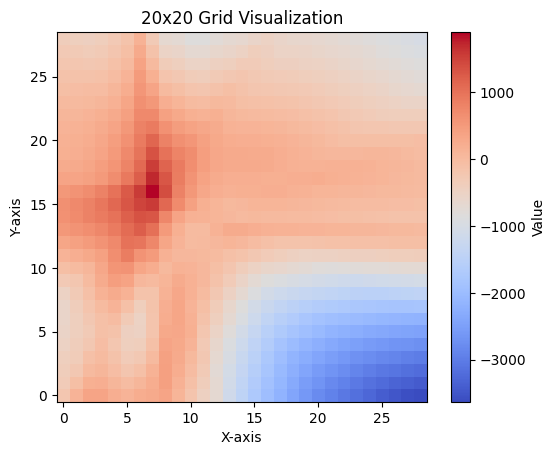

In [61]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'vals' is your tensor of 400 values
vals_np = vals.detach().cpu().numpy()  # Convert tensor to numpy array

# Reshape the values into a 20x20 grid
grid = vals_np.reshape((29, 29))

# Create a colormap with a gradient from blue (min) to red (max)
cmap = plt.get_cmap('coolwarm')

# Plot the heatmap
plt.imshow(grid, cmap=cmap, origin='lower')

# Add a color bar to show the scale
plt.colorbar(label='Value')

# Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('20x20 Grid Visualization')

# Show the plot
plt.show()